In [1]:
%config IPCompleter.greedy=True

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import variational_autoencoder as vae
import weapon_data as weapons

print("Tensor Flow version {}".format(tf.__version__))

D:\z_outsourced_programs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor Flow version 1.8.0


# Test Utils

In [3]:
#test utils
def print_decoded_tensors_as_dict(weapon_data, array_of_tensors):
    genDict = {}
    
    for tensor in array_of_tensors:
        decoded, _ = weapon_data.decode_processed_tensor(tensor)
        
        for key, value in decoded.items():
            if key not in genDict:
                genDict[key] = []
            genDict[key].append(value)
    
    for key, value in genDict.items():
            print(key, "=", value)
            
            
def get_weapon_data():
    return weapons.get_data()

# Initial VAE Training
Initializes all network hyperparameters and shows training debug messages of the training epoch and cost. Trains and saves the trained model in the specified folder.

In [4]:
network_architecture = \
    dict(n_input=0, #set it in with scope
         n_hidden_1=26,
         n_hidden_2=12,
         n_z=2)  

learning_rate = 0.01
optimizer =  tf.train.RMSPropOptimizer(learning_rate)
transfer_fct = tf.nn.elu
num_epochs = 70
batch_size = 4
epoch_debug_step = 1
saved_model_folder = "trained_vae/"
saved_model_full_path = saved_model_folder + "model.ckpt"
    
with tf.Session() as sess:
    train_data, test_data = get_weapon_data()
    network_architecture['n_input'] = train_data.num_features
  
    network = vae.get_new_trained(sess, train_data, network_architecture, optimizer, 
                              transfer_fct, batch_size, num_epochs, epoch_debug_step,
                                  trained_model_save_path=saved_model_folder)


Epoch:0001 - Cost:23.617572064
Epoch:0011 - Cost:14.608607795
Epoch:0021 - Cost:12.335476567
Epoch:0031 - Cost:10.586388475
Epoch:0041 - Cost:9.893884148
Epoch:0051 - Cost:9.277483467
Epoch:0061 - Cost:9.140962165
Epoch:0071 - Cost:9.000186184
Epoch:0081 - Cost:8.614526613
Epoch:0091 - Cost:8.959885064
Trained model saved! You can find it in 'trained_vae/model.ckpt'


In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, saved_model_full_path)
        
    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(batch_size)
    x_reconstructed = network.encode_and_decode(samples, True)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,x_reconstructed), axis=0))


with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, saved_model_full_path)

    train_data, test_data = get_weapon_data()
    
    samples = test_data.next_batch(1)
    x_reconstructed_mean = network.encode_and_decode(samples, False)
    print_decoded_tensors_as_dict(test_data, np.concatenate((samples,[x_reconstructed_mean]), axis=0))

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['53.0', '38.0', '26.5', '80.0', '37.89492652573062', '26.65606312068924', '23.79198639529914', '62.39835360928358']
damages_last = ['38.0', '21.5', '23.0', '80.0', '27.46572387481021', '14.988826466137976', '18.614333537477854', '58.56348625261825']
distances_first = ['66.0', '10.0', '11.0', '0.0', '48.88168353470817', '19.64925903036779', '17.391440890339496', '-0.11127666611915643']
distances_last = ['89.0', '47.0', '35.0', '115.0', '64.22178113002585', '30.102388081758363', '36.991737064666424', '117.24233935705647']
firemode_Automatic = ['0.0', '1.0', '1.0', '0.0', '0.1687243513476785', '1.2568338116308433', '1.2486967670138993', '0.24183799416943913']
firemode_Semi = ['1.0', '0.0', '0.0', '0.0', '0.7952171424433059', '-0.09233417190392307', '-0.0752946479876434', '-0.05574152280592709']
firemode_Single = ['0.0', '0.0', '0.0', '1.0', '-0.011140455087980311', '-0.07624311032057468', '-0.104022998498415

In [6]:
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, saved_model_full_path)
    
    avg_cost_rand = 0.
    avg_cost = 0.

    _, test_data = get_weapon_data()
    num_samples = test_data.num_examples
    total_batch = int(num_samples / batch_size)

    # Loop over all batches
    for i in range(total_batch):
        batch = test_data.next_batch(batch_size)
        cost = network.calculate_loss(batch)        

        rand_sample = np.random.uniform(low=test_data.standardized_min_values, 
                                       high=test_data.standardized_max_values, 
                                       size=(batch_size,network_architecture["n_input"]))
        cost_rand = network.calculate_loss(rand_sample)

        print("Random Cost = " + "{:.2f}".format(cost_rand))

        #compute average loss/cost
        avg_cost_rand += min(cost_rand,1000) / batch_size
        avg_cost += cost / batch_size
    
    print("Random input average cost = " + "{:.2f}".format(avg_cost_rand))   
    print("Test data input average cost = " + "{:.2f}".format(avg_cost))


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
Random Cost = 863006129064466306717188096.00
Random Cost = 520385940761824198656.00
Random Cost = 362522740767233933312.00
Random Cost = 262617504350930259148800.00
Random Cost = 1441600974083900571648.00
Random input average cost = 1250.00
Test data input average cost = 13.32


INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt


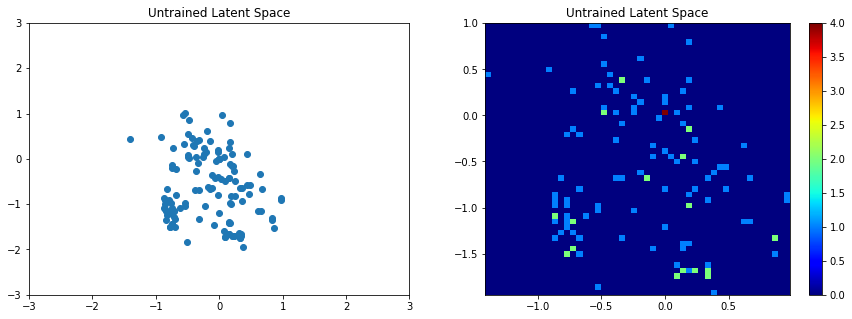

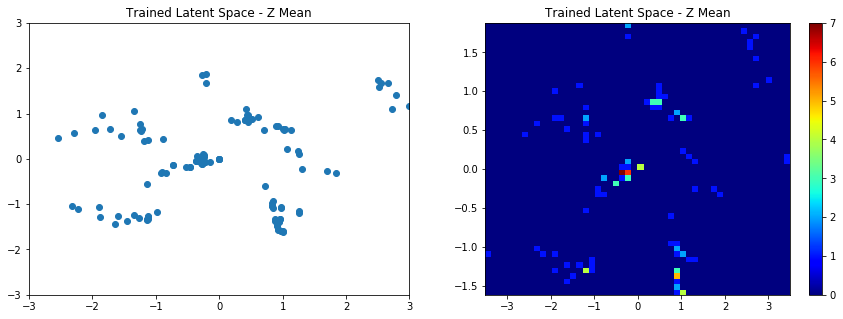

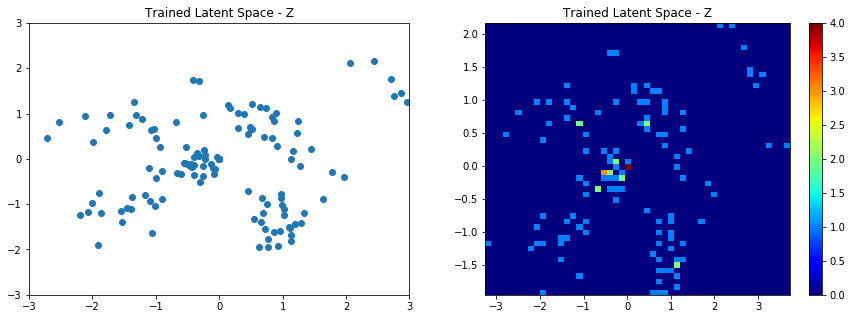

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_z_distribution(vae_model, title, z_mean=True):
    all_z = np.zeros((batch_size,network_architecture['n_z']))
        
    train_data, test_data = get_weapon_data()
    total_batch = int(train_data.num_examples / batch_size) 

    # Loop over all batches
    for i in range(total_batch):
        batch = train_data.next_batch(batch_size)
        z_dist = vae_model.calculate_z(batch)
        if z_mean:
            z_dist = vae_model.calculate_z_mean(batch)
        all_z = np.vstack((all_z, z_dist))

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(all_z[:,0], all_z[:,1])
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.title(title)
    plt.subplot(1,2,2)
    plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    show_z_distribution(network, "Untrained Latent Space", z_mean=True)
    network = vae.restore(network, "trained_vae/model.ckpt")
    show_z_distribution(network, "Trained Latent Space - Z Mean", z_mean=True)    
    show_z_distribution(network, "Trained Latent Space - Z", z_mean=False)

In [8]:
# Testing single input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, saved_model_full_path)
    
    generated = []

    random_val = np.random.normal(size=(1,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, False)
    #[generated.append(x) for x in x_test]
    generated.append(x_test)  
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['46.00053235509399']
damages_last = ['15.496031502175715']
distances_first = ['9.709596455463608']
distances_last = ['36.70804089825909']
firemode_Automatic = ['-0.12347885851284673']
firemode_Semi = ['0.9607769735732743']
firemode_Single = ['0.14415791335246428']
hiprecoildec = ['5.029731452833548']
hiprecoilright = ['0.8125239056936049']
hiprecoilup = ['4.50310239152686']
hipstandbasespreaddec = ['7.610609976731748']
hipstandbasespreadinc = ['0.2126398313973004']
initialspeed = ['292.8350655237324']
magsize = ['2.4241567912707502']
reloadempty = ['3.0024942970790214']
rof = ['218.93758652749437']
shotspershell = ['2.5596298044090386']
type_Shotgun = ['0.2724487575488136']
type_Pistol = ['0.791027101056477']
type_Rifle = ['-0.06260916783686274']
type_SMG = ['0.05114650690321665']
type_Sniper = ['-0.06354016442611252']
type_MG = ['-0.006823653689000259']


In [9]:
# Testing batch input in latent space
with tf.Session(graph=tf.Graph()) as sess:
    network = vae.get_untrained(sess, network_architecture, optimizer, transfer_fct, batch_size)
    network = vae.restore(network, saved_model_full_path)
    
    generated = []

    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    
    random_val = np.random.normal(size=(batch_size,network_architecture["n_z"]))
    x_test = network.decode_from_latent_space(random_val, True)
    [generated.append(x) for x in x_test]
    
    train_data, test_data = get_weapon_data()
    print_decoded_tensors_as_dict(train_data, generated)

INFO:tensorflow:Restoring parameters from trained_vae/model.ckpt
damages_first = ['57.350382487994096', '39.542392936668556', '34.43295537900569', '41.9358825029834', '34.851905079931655', '29.009807888391567', '32.61516831507675', '29.005021589353728']
damages_last = ['18.68210449958675', '31.424828899188004', '30.004464309014146', '32.22041998084158', '19.01860748918468', '19.829479464910058', '10.034280066231037', '21.997596940925714']
distances_first = ['10.737566060525264', '41.93602777180667', '27.813289462367962', '43.38191466622272', '10.51355357210354', '17.16271072244656', '8.844383274416103', '20.760934020932815']
distances_last = ['35.99565382431098', '71.83350575484778', '62.06986272834432', '74.09109614610081', '34.87632066763851', '38.33105247654855', '28.70744307385973', '44.45388704516844']
firemode_Automatic = ['-0.0507381557306163', '0.2526823156346969', '0.6356565872577251', '0.13202659851817072', '1.0867007908302886', '1.098955525750714', '-0.02846820311594145', '0